In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

In [2]:
#exchange_data = pd.read_csv('USD_VND Historical Data.csv')
#exchange_data = pd.read_csv('USD_EUR Historical Data.csv')
exchange_data = pd.read_csv('USD_RUB Historical Data.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,90.36,89.36,90.5701,88.8773,NaN,1.12%
1,12/28/2023,89.36,91.27,91.2700,89.2805,NaN,-2.09%
2,12/27/2023,91.27,91.66,91.9793,91.2369,NaN,-0.43%
3,12/26/2023,91.66,91.75,91.9388,91.3750,NaN,-0.10%
4,12/25/2023,91.75,92.00,92.1875,91.6576,NaN,-0.27%


In [3]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [4]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-12-29,90.36,89.36,90.5701,88.8773,NaN,1.12%
2023-12-28,89.36,91.27,91.2700,89.2805,NaN,-2.09%
2023-12-27,91.27,91.66,91.9793,91.2369,NaN,-0.43%
2023-12-26,91.66,91.75,91.9388,91.3750,NaN,-0.10%
2023-12-25,91.75,92.00,92.1875,91.6576,NaN,-0.27%


In [5]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price,Vol.
Date,,,,,,
2010-01-01,0.00%,30.3135,30.1000,30.1000,30.1000,NaN
2010-01-04,0.72%,30.5450,30.1000,30.1000,30.3175,NaN
2010-01-05,-0.72%,30.3175,29.9060,30.3175,30.1000,NaN
2010-01-06,0.00%,30.1000,29.8565,30.1000,30.1000,NaN
2010-01-07,0.00%,30.1000,29.8250,30.1000,30.1000,NaN


<Axes: xlabel='Date'>

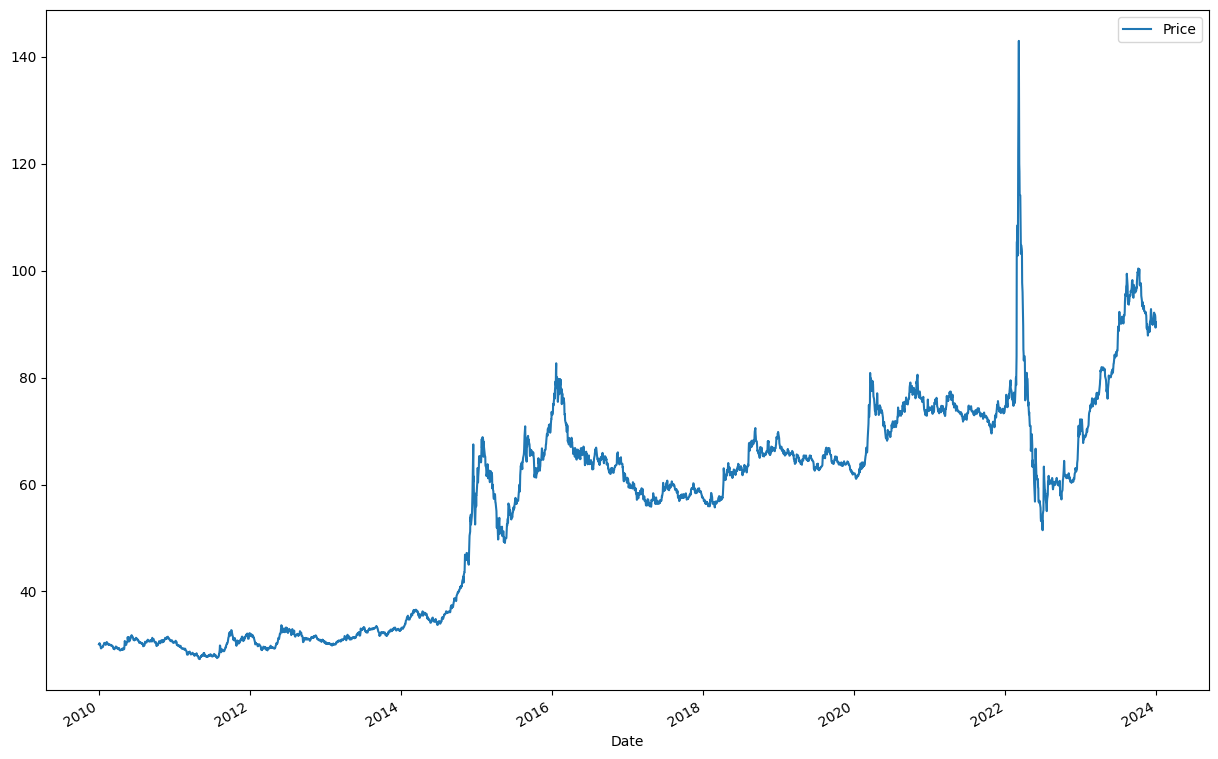

In [6]:
df = data_frame[["Price"]]
#visualize the pattern of prices over the years
df.plot(kind='line',figsize=(15,10))

 dataset in terms of years and further check 100% of the dataset lies within which interval

In [7]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("100 percent data = 2010 to %d"%(2010 + int(1*years)))

Total data: 14 years
100 percent data = 2010 to 2024


In [8]:
# Summary Statistics
df.describe()

,Price
count,3593.000000
mean,55.239082
std,19.392387
min,27.341500
25%,32.377000
50%,60.600000
75%,68.657700
max,143.000000


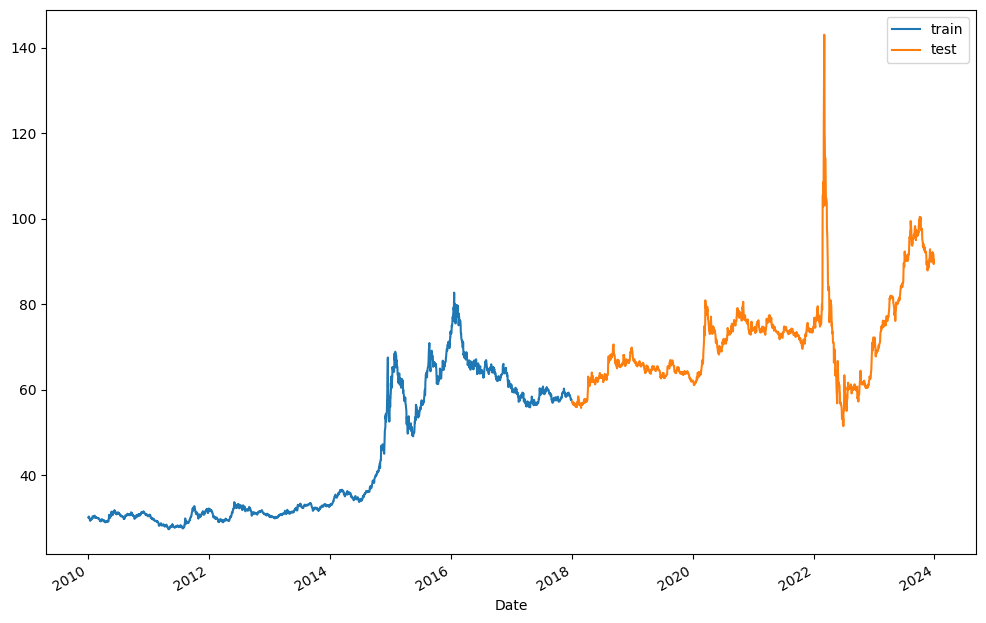

In [9]:
# Train Test Split
split_date = pd.Timestamp('01-01-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

### Data Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
X_train

array([[-0.86585799],
       [-0.85165347],
       [-0.86585799],
       ...,
       [ 0.93161693],
       [ 0.93941472],
       [ 0.92458325]])

### GRU

In [14]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7)              │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218 (872.00 B)

 Trainable params: 218 (872.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
model_gru.compile(loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])
print("The model has successfully trained")


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0324 - rmse: 0.1765
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - rmse: 0.0459 
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - rmse: 0.0600
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - rmse: 0.0571
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - rmse: 0.0567
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - rmse: 0.0548
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - rmse: 0.0529
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - rmse: 0.0510
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - rmse: 0.0491
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - rmse: 0.0474
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - rmse: 0.0458
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 13/100
65/65 ━━━━━

In [16]:
#model_gru.save('gru.h5')
#print("Saving the model as gru.h5")

#model_gru.save('gru_EUR.h5')
#print("Saving the model as gru_EUR.h5")

model_gru.save('gru_RUB.h5')
print("Saving the model as gru_RUB.h5")


Saving the model as gru_RUB.h5


### GRU Prediction

In [17]:
y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

def adj_r2_score(r2, n, k):
  return 1-((1-r2)*((n-1)/(n-k-1)))
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
The R2 score on the Train set is:	0.998
The  MAE on the Train set is:	0.022
The  RMSE on the Train set is:	0.039
The Adjusted R2 score on the Train set is:	0.998

The R2 score on the Test set is:	0.978
The Adjusted R2 score on the Test set is:	0.978
The  MAE on the Test set is:	0.052
The  RMSE on the Test set is:	0.104


### GRU Prediction Plot

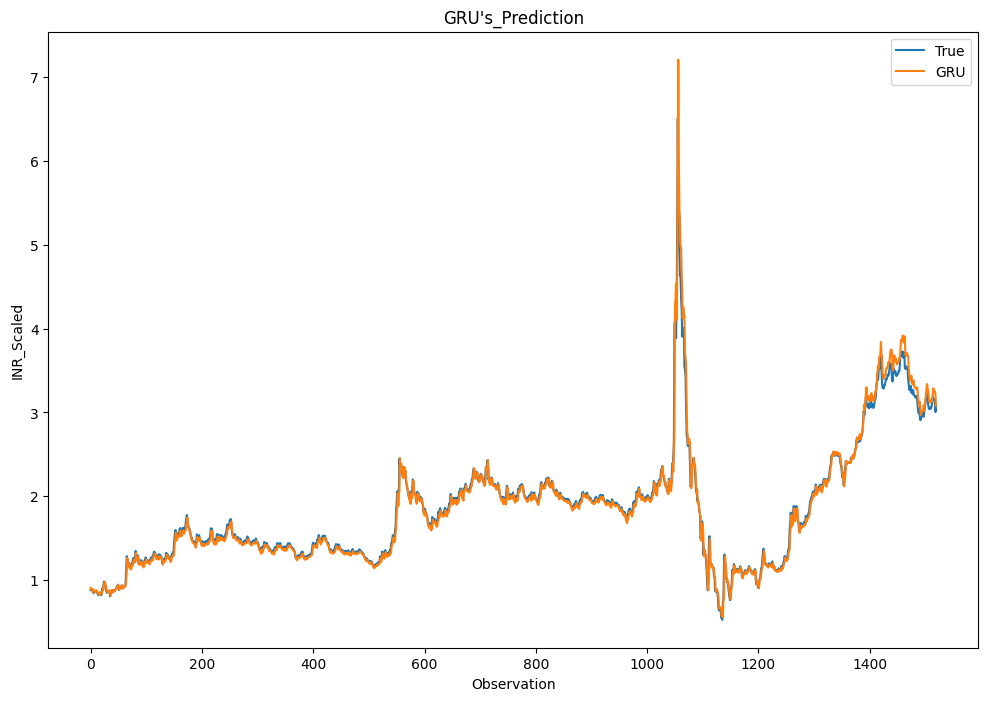

In [18]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [19]:
inv_yhat = sc.inverse_transform(y_pred_test_gru)

inv_yhat

array([[57.289825],
       [56.93472 ],
       [57.041187],
       ...,
       [93.13604 ],
       [92.68741 ],
       [90.49835 ]], dtype=float32)

In [20]:
inv_ytest = sc.inverse_transform(y_test)

inv_ytest

array([[56.8765],
       [56.9903],
       [56.993 ],
       ...,
       [91.27  ],
       [89.36  ],
       [90.36  ]])

In [21]:
test_mse = metrics.mean_squared_error(inv_ytest, inv_yhat)
rmse_test = np.sqrt(test_mse)


print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(inv_ytest, inv_yhat)))
r2_test = r2_score(inv_ytest, inv_yhat)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(inv_ytest, inv_yhat)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Test set is:	0.978
The Adjusted R2 score on the Test set is:	0.978
The  MAE on the Test set is:	0.797
The  RMSE on the Test set is:	1.598


In [22]:
test.head()

,Price
Date,
2018-01-03,57.2561
2018-01-04,56.8765
2018-01-05,56.9903
2018-01-09,56.9930
2018-01-10,57.0222


In [23]:
col1 = pd.DataFrame(inv_ytest, columns=['Price'])
col2 = pd.DataFrame(inv_yhat, columns=['GRU_prediction'])
col3 = pd.DataFrame(history_model_gru.history['rmse'], columns=['RMSE'])
results = pd.concat([col1, col2, col3], axis=1)
#results.to_csv('Prediction_MONEY_INR_GRU.xlsx')

In [24]:
results.head()

,Price,GRU_prediction,RMSE
0,56.8765,57.289825,0.151657
1,56.9903,56.934719,0.062183
2,56.9930,57.041187,0.065090
3,57.0222,57.043713,0.061591
4,56.4285,57.071030,0.059540


In [25]:
test.reset_index(level=0, inplace=True)
test.head()

,Date,Price
0,2018-01-03,57.2561
1,2018-01-04,56.8765
2,2018-01-05,56.9903
3,2018-01-09,56.9930
4,2018-01-10,57.0222


In [26]:
dfinal = test.merge(results, how='inner', left_on='Price', right_on='Price')

In [27]:
dfinal.drop_duplicates(subset="Date",inplace=True)


dfinal.head()

,Date,Price,GRU_prediction,RMSE
0,2018-01-04,56.8765,57.289825,0.151657
2,2018-01-05,56.9903,56.934719,0.062183
3,2018-01-09,56.9930,57.041187,0.065090
4,2018-01-10,57.0222,57.043713,0.061591
5,2018-01-11,56.4285,57.071030,0.059540


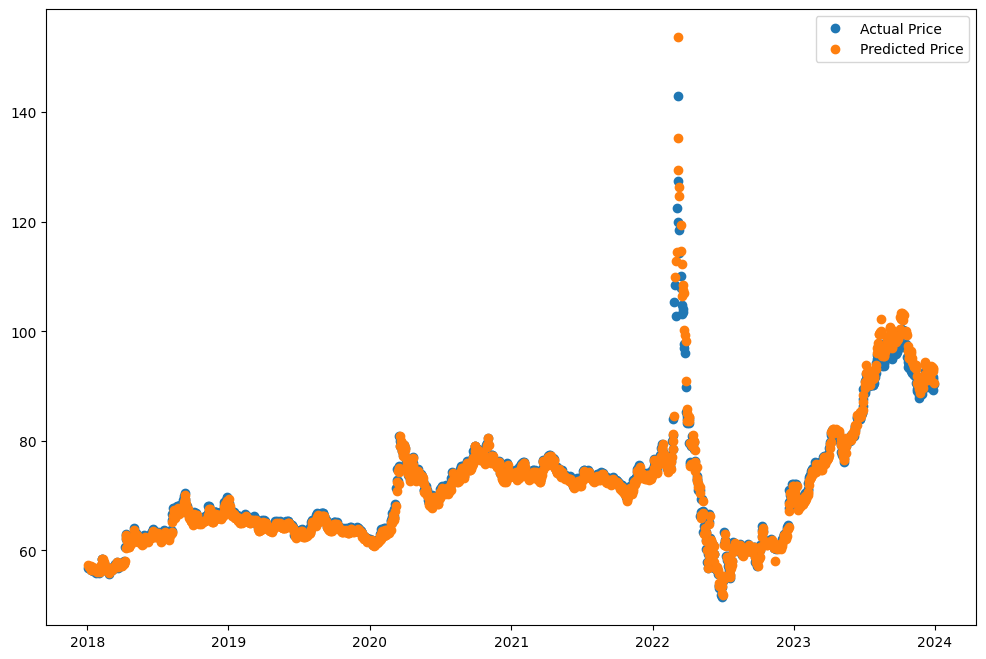

In [28]:
plt.figure(figsize=(12,8))
price_date = dfinal['Date']
price_true = dfinal['Price']
price_pred = dfinal['GRU_prediction']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [29]:
dfinal.describe()

,Date,Price,GRU_prediction,RMSE
count,1517,1517.000000,1517.000000,51.000000
mean,2021-01-03 16:17:43.150956032,71.357186,71.297546,0.049418
min,2018-01-04 00:00:00,51.450000,51.814873,0.039616
25%,2019-07-05 00:00:00,63.762800,63.413219,0.040323
50%,2021-01-08 00:00:00,70.492800,69.994080,0.042813
75%,2022-07-07 00:00:00,75.445000,75.122375,0.048460
max,2023-12-29 00:00:00,143.000000,153.686371,0.151657
std,NaN,10.570829,11.243888,0.021874


In [30]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained GRU model
#model = load_model('gru.h5')
#model = load_model('gru_EUR.h5')
model = load_model('gru_RUB.h5')

# Define input features and preprocessing
def preprocess_input(input_data):
    # Perform any necessary preprocessing here (e.g., scaling)
    # For simplicity, we'll just return the input as is
    input_data = sc.transform(input_data)
    return input_data

# Function to get user input
def get_user_input():
    # Collect input features from the user
    usd_to_money = float(input("Enter USD for exchange rate: "))

    # Add more features as needed
    return usd_to_money

# Make predictions
def predict_exchange_rate(model, input_features):
    # Reshape input features to match model input shape
    input_features = np.array(input_features).reshape(1, len(input_features))
    # Preprocess input
    preprocessed_input = preprocess_input(input_features)
    # Make prediction
    predicted_exchange_rate = model.predict(preprocessed_input)
    predicted_exchange_rate = sc.inverse_transform(predicted_exchange_rate)
    return predicted_exchange_rate

# Display results
def display_results(prediction):
    print("Predicted exchange rate:", prediction)

# Main function
def main():
    # Get user input
    usd_to_money = get_user_input()

    # Combine input features
    input_features = [usd_to_money]

    # Make predictions
    predicted_exchange_rate = predict_exchange_rate(model, input_features)

    # Display results
    display_results(predicted_exchange_rate)

if __name__ == "__main__":
    main()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted exchange rate: [[96.99796]]
